In [1]:
# !git clone https://github.com/pettepiero/Dial-a-ride.git
# %cd Dial-a-ride/
# !pip install virtualenv
# !virtualenv vrpenv # To set up the env
# !source /content/Dial-a-ride/vrpenv/bin/activate
# !source /content/Dial-a-ride/vrpenv/bin/activate

In [2]:
import copy
import random
from types import SimpleNamespace
from typing import List
import pandas as pd
import vrplib

from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import *
from alns.stop import MaxIterations

import sys
sys.path.append('..')

from myvrplib import plot_solution, plot_data, solution_times_statistics, LOGGING_LEVEL
# from cvrptw.myvrplib import plot_solution, plot_data, solution_times_statistics, LOGGING_LEVEL
from data_module import data, END_OF_DAY, read_solution_format
from route import Route
from vrpstates import CvrptwState
from initial_solutions.initial_solutions import nearest_neighbor_tw, time_neighbours
from operators.destroy import *
from operators.repair import *
from operators.wang_operators import *
from analyze_solution import verify_time_windows

In [3]:
%matplotlib inline
SEED = 1234
from myvrplib import END_OF_DAY

In [4]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=LOGGING_LEVEL)

# Implementation of wang 2024
https://www.sciencedirect.com/science/article/pii/S0360835224002432?via%3Dihub

NOTE: data['dimension'] is the number of customers only, not including depots

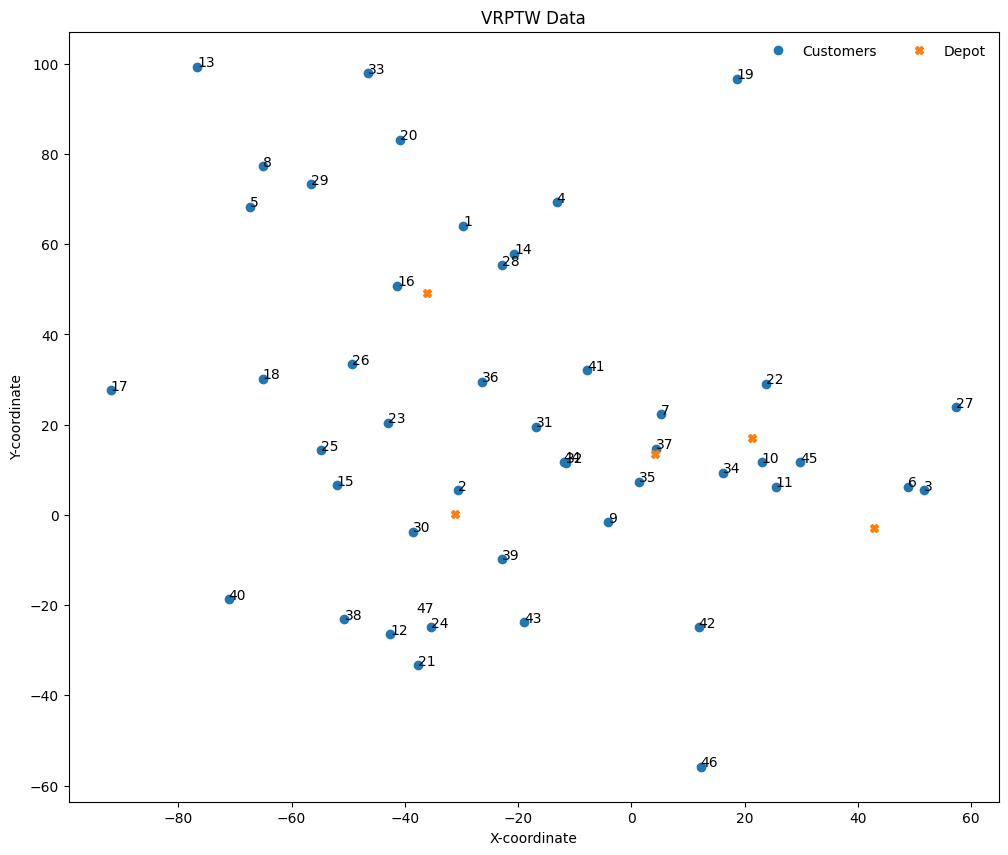

In [5]:
plot_data(data, idx_annotations=True)

## Solution state

In [9]:
def get_customer_info(data, state: CvrptwState, idx: int, cordeau: bool = False):
    """
    Get the customer information for the passed-in index.
    """
    if cordeau:
        if idx == 0:
            print("Error: in Cordeau notation index 0 is a fake customer")
            return
        
    route = state.find_route(idx)
    if route is not None:
        index_in_route = state.find_index_in_route(idx, route)
        route_index = state.routes.index(route)
        print(f"index_in_route: {index_in_route}")
        print(f"route: {route}")

        dict = {
            "index": idx,
            "coords": data["node_coord"][idx],
            "demand": data["demand"][idx].item(),
            "ready time": data["time_window"][idx][0].item(),
            "due time": data["time_window"][idx][1].item(),
            "service_time": data["service_time"][idx].item(),
            "route": route,
        }
    else:
        print(f"Customer {idx} is not in any route")
        dict = {
            "index": idx,
            "coords": data["node_coord"][idx],
            "demand": data["demand"][idx].item(),
            "ready time": data["time_window"][idx][0].item(),
            "due time": data["time_window"][idx][1].item(),
            "service_time": data["service_time"][idx].item(),
            "route": None,
        }
    return dict

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [10]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)
print(f"Removing {customers_to_remove} customers.")

Removing 2 customers.


## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost. Time window constraints are implemented as follows in the **greedy repair**:

1)  Within the set of unvisited nodes, first find those nodes that can be visited within the node's time window from the current end of each existing route
2)  Add the node that is nearest to the end of some route to that route
3)  If no unvisited nodes can be visited on time, make a new route just for that node

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

### Choosing starting depot
If the number of vehicles if larger than number of depots we split the number of vehicles between the depots.

Otherwise, we choose randomly a depot and generate a route from it.
NOTE: maybe performance of the model can be improved by changing the above policy

In [11]:
# calculate_depots(data)
print(data['depot_to_vehicles'])
print(data['vehicle_to_depot'])
print(data['dimension'])

{48: [], 49: [], 50: [0], 51: [1]}
{0: 50, 1: 51}
48


In [12]:
print(data['depots'])

[48, 49, 50, 51]


Vehicles left: 1


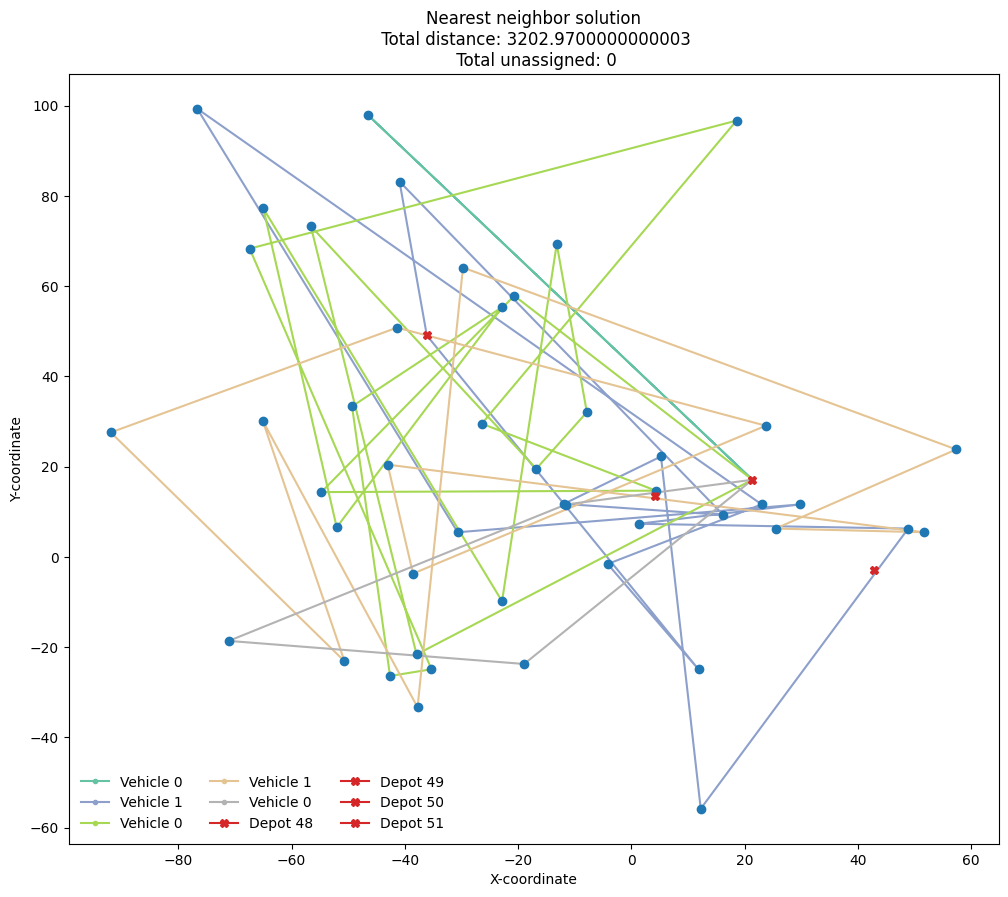

In [13]:
initial_solution = nearest_neighbor_tw()

plot_solution(data, initial_solution, "Nearest neighbor solution")

In [14]:
for route in initial_solution.routes:
    print(route.customers_list)

[50, 33, 50]
[51, 42, 9, 10, 13, 2, 45, 35, 6, 46, 7, 44, 34, 20, 51]
[50, 47, 29, 31, 41, 4, 39, 8, 15, 28, 26, 12, 24, 5, 19, 36, 37, 25, 14, 50]
[51, 22, 30, 23, 3, 11, 27, 1, 21, 18, 38, 17, 16, 51]
[50, 32, 40, 43, 50]


In [15]:
initial_solution_stats = solution_times_statistics(data, initial_solution)
print(initial_solution_stats)

Inside solution_times_statistics
{'late': 34, 'early': 0, 'ontime': 13, 'left_out_customers': 1, 'late_minutes_sum': 13268.29, 'early_minutes_sum': 0.0}


## Heuristic solution

Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we do not actually use any adaptive operator selection -- but you can easily add more destroy and repair r_operators. 

In [16]:
# alns = ALNS(rnd.default_rng(SEED))
alns = ALNS(rnd.default_rng())

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(random_route_removal)
alns.add_destroy_operator(cost_reducing_removal)
alns.add_destroy_operator(worst_removal)
# alns.add_destroy_operator(exchange_reducing_removal)  #to be implemented
# alns.add_destroy_operator(shaw_removal)   #to be implemented

alns.add_repair_operator(greedy_repair_tw)
alns.add_repair_operator(wang_greedy_repair)

DEBUG:alns.ALNS:Adding destroy operator random_removal.
DEBUG:alns.ALNS:Adding destroy operator random_route_removal.
DEBUG:alns.ALNS:Adding destroy operator cost_reducing_removal.
DEBUG:alns.ALNS:Adding destroy operator worst_removal.
DEBUG:alns.ALNS:Adding repair operator greedy_repair_tw.
DEBUG:alns.ALNS:Adding repair operator wang_greedy_repair.


In [17]:
num_iterations = 200
init = nearest_neighbor_tw()
# select = AlphaUCB([25, 5, 1, 0], 0.1, 4, 2)
select = RouletteWheel([25, 5, 1, 0], 0.8, 4, 2)
# select = RandomSelect(num_destroy=4, num_repair=2)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result, destruction_counts, insertion_counts, d_operators_log, r_operators_log = alns.iterate(init, select, accept, stop, data=data, save_plots=True)

DEBUG:alns.ALNS:Initial solution has objective 3202.97.
DEBUG:alns.ALNS:
save_plots is True



INFO:alns.ALNS:New best with objective 3146.81.


Vehicles left: 1
Saving plots to folder /home/pettepiero/tirocinio/dial-a-ride/outputs/plots/20250114143218


INFO:alns.ALNS:New best with objective 3029.68.
INFO:alns.ALNS:New best with objective 2978.52.
INFO:alns.ALNS:New best with objective 2802.03.
INFO:alns.ALNS:New best with objective 2791.55.
INFO:alns.ALNS:New best with objective 2756.78.
INFO:alns.ALNS:New best with objective 2738.33.
INFO:alns.ALNS:New best with objective 2721.10.
INFO:alns.ALNS:New best with objective 2691.35.
INFO:alns.ALNS:New best with objective 2571.86.
INFO:alns.ALNS:New best with objective 2516.24.
INFO:alns.ALNS:New best with objective 2515.72.
INFO:alns.ALNS:New best with objective 2401.66.
INFO:alns.ALNS:New best with objective 2333.88.
INFO:alns.ALNS:New best with objective 2318.29.
INFO:alns.ALNS:New best with objective 2094.70.
INFO:alns.ALNS:New best with objective 1989.77.
INFO:alns.ALNS:New best with objective 1987.46.
INFO:alns.ALNS:New best with objective 1973.59.
INFO:alns.ALNS:New best with objective 1868.33.
INFO:alns.ALNS:New best with objective 1832.66.
INFO:alns.ALNS:New best with objective 1

In [18]:
d_operators = tuple([op[0] for op in alns.destroy_operators])
print(d_operators)
d_ops_dict = {i: op for i, op in enumerate(d_operators)}

('random_removal', 'random_route_removal', 'cost_reducing_removal', 'worst_removal')


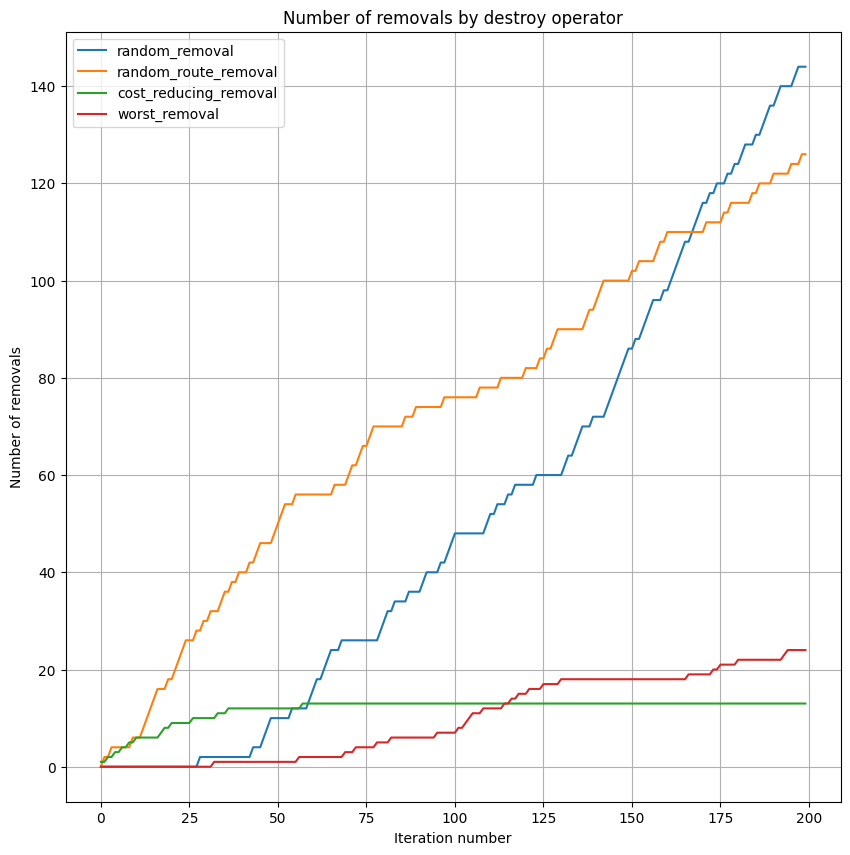

In [19]:
cumulative_sums = np.cumsum(destruction_counts, axis=0)  # Plot each column
rows = np.arange(destruction_counts.shape[0])
fig, ax = plt.subplots(figsize=(10,10))
for col_idx in range(destruction_counts.shape[1]-1):
    plt.plot(rows, cumulative_sums[:, col_idx], label=f"{d_operators[col_idx]}")

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of removals")
plt.title("Number of removals by destroy operator")
plt.legend()
plt.grid(True)
plt.show()

('greedy_repair_tw', 'wang_greedy_repair')


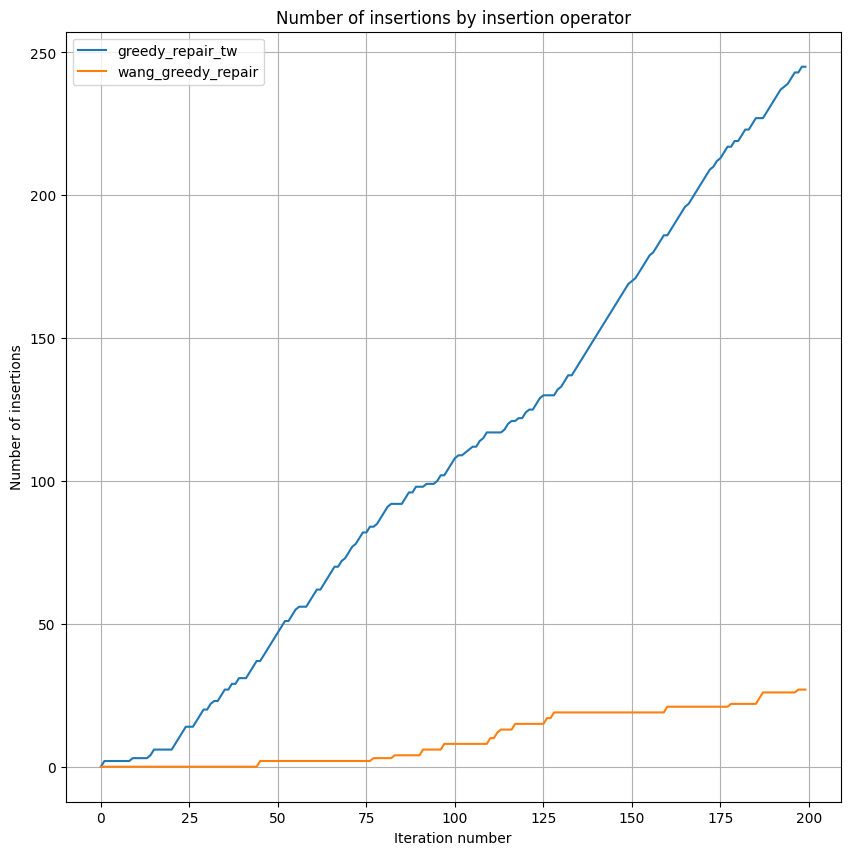

In [20]:
r_operators = tuple([op[0] for op in alns.repair_operators])
r_ops_dict = {i: op for i, op in enumerate(r_operators)}
print(r_operators)
cumulative_sums = np.cumsum(insertion_counts, axis=0)  # Plot each column
rows = np.arange(insertion_counts.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(insertion_counts.shape[1] - 1):
    plt.plot(rows, cumulative_sums[:, col_idx], label=f"{r_operators[col_idx]}")

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of insertions")
plt.title("Number of insertions by insertion operator")
plt.legend()
plt.grid(True)
plt.show()

## Plotting the destroy and repair operators applications

In [21]:
destroy_operators_log_array = np.zeros(shape=(len(d_operators_log), len(d_operators)), dtype=int)
for i, op in enumerate(d_operators_log):
    destroy_operators_log_array[i, op] +=1
destroy_operators_log_array = np.cumsum(destroy_operators_log_array, axis=0)

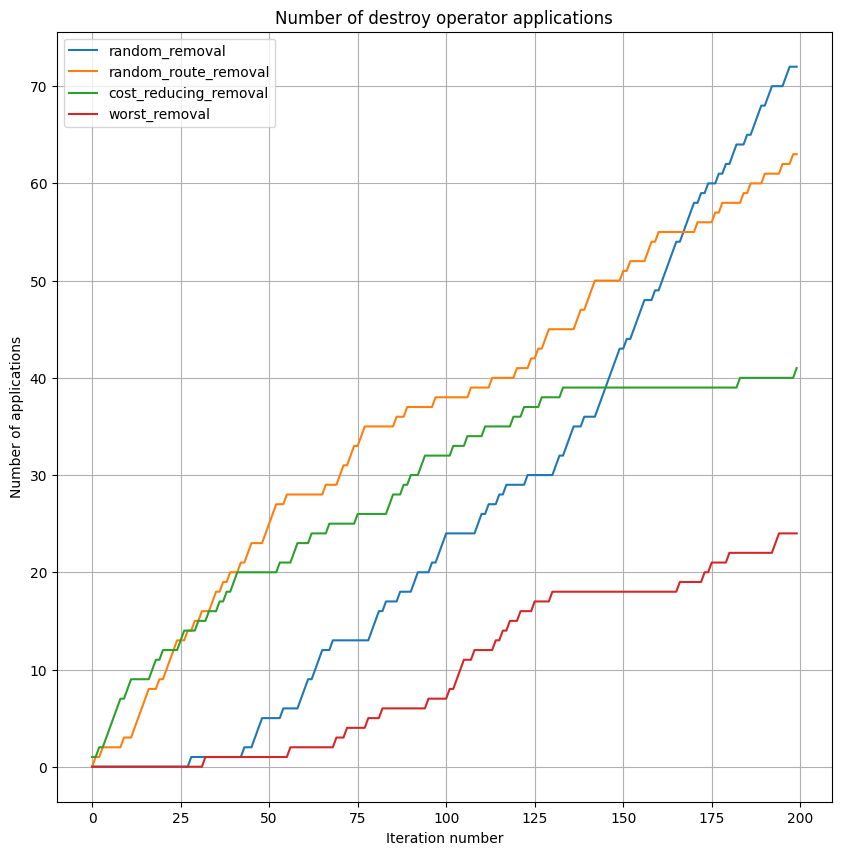

In [22]:
rows = np.arange(destroy_operators_log_array.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(destroy_operators_log_array.shape[1]):
    plt.plot(
        rows, destroy_operators_log_array[:, col_idx], label=f"{d_operators[col_idx]}"
    )

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of applications")
plt.title("Number of destroy operator applications")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_58469/518890836.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


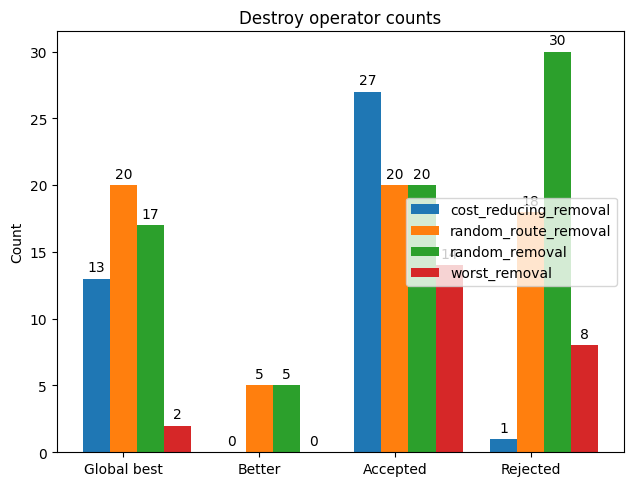

In [23]:
results_df = pd.DataFrame(result.statistics.destroy_operator_counts)
reasons = ["Global best", "Better", "Accepted" , "Rejected"]
x = np.arange(len(reasons))
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.tight_layout()
for attribute, measurement in results_df.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Destroy operator counts')
ax.set_xticks(x + width, reasons)
ax.legend(loc='right', ncols=1)
# ax.set_xlim(0, 4)

plt.show()

In [24]:
repair_operators_log_array = np.zeros(
    shape=(len(r_operators_log), len(r_operators)), dtype=int
)
for i, op in enumerate(r_operators_log):
    repair_operators_log_array[i, op] += 1
repair_operators_log_array = np.cumsum(repair_operators_log_array, axis=0)

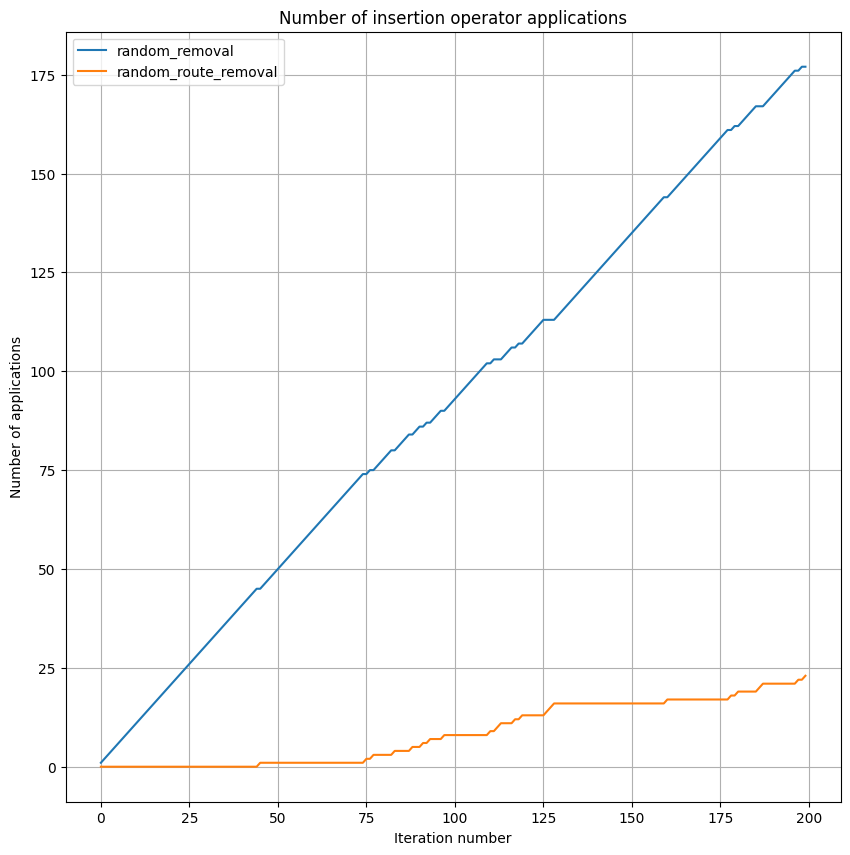

In [25]:
rows = np.arange(repair_operators_log_array.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(repair_operators_log_array.shape[1]):
    plt.plot(
        rows, repair_operators_log_array[:, col_idx], label=f"{d_operators[col_idx]}"
    )

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of applications")
plt.title("Number of insertion operator applications")
plt.legend()
plt.grid(True)
plt.show()

   greedy_repair_tw  wang_greedy_repair
0                52                   0
1                 9                   1
2                73                   8
3                43                  14


(0.0, 4.0)

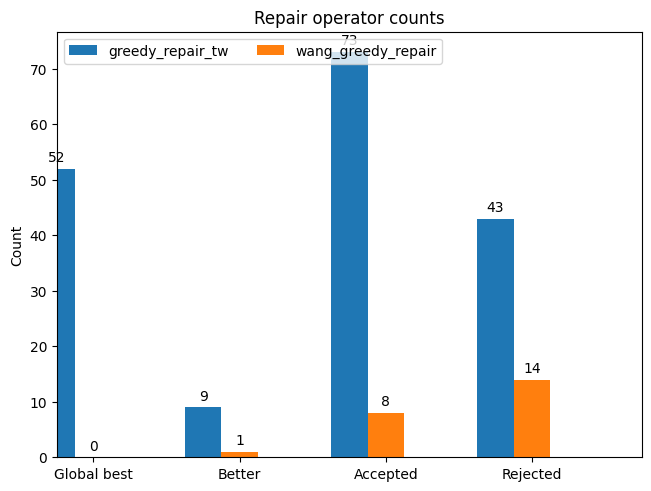

In [26]:
results_df = pd.DataFrame(result.statistics.repair_operator_counts)
print(results_df)

reasons = ["Global best", "Better", "Accepted", "Rejected"]
x = np.arange(len(reasons))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for attribute, measurement in results_df.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Count")
ax.set_title("Repair operator counts")
ax.set_xticks(x + width, reasons)
ax.legend(loc="upper left", ncols=4)
ax.set_xlim(0, 4)

## Overall results

In [27]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 573.21.


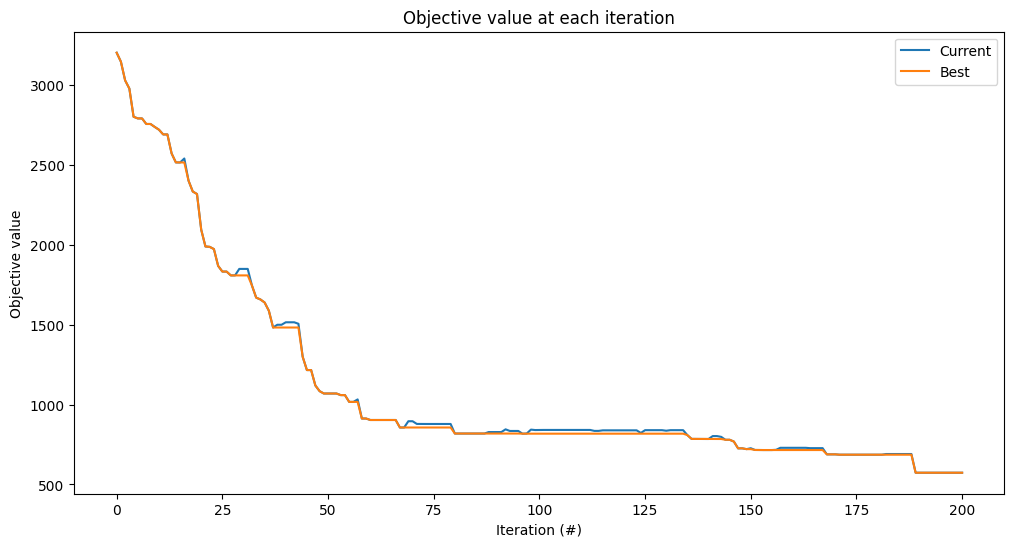

In [28]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [29]:
plot_solution(data, initial_solution, "Nearest-neighbor-solution", save=True, figsize=(8, 8))
plot_solution(data, solution, "Heuristic-solution", idx_annotations=False, save=True, figsize=(8, 8))

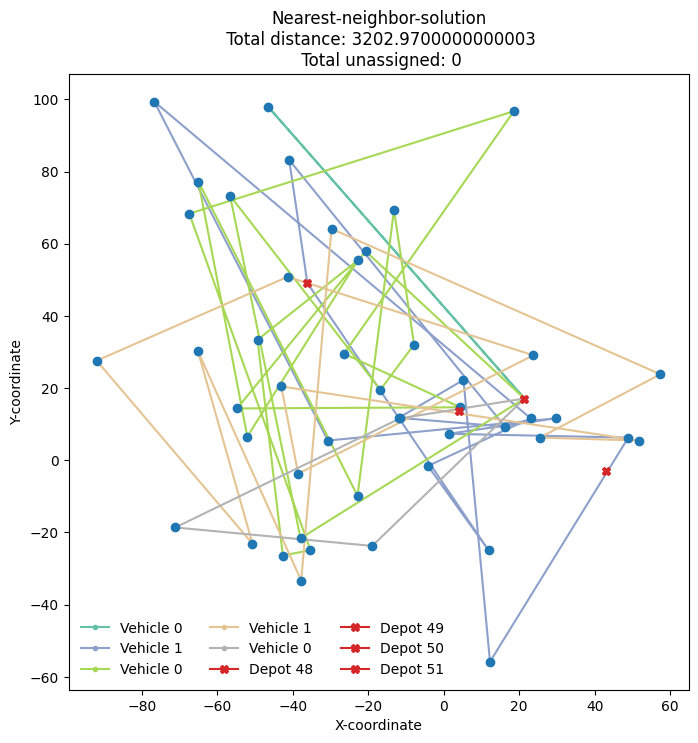

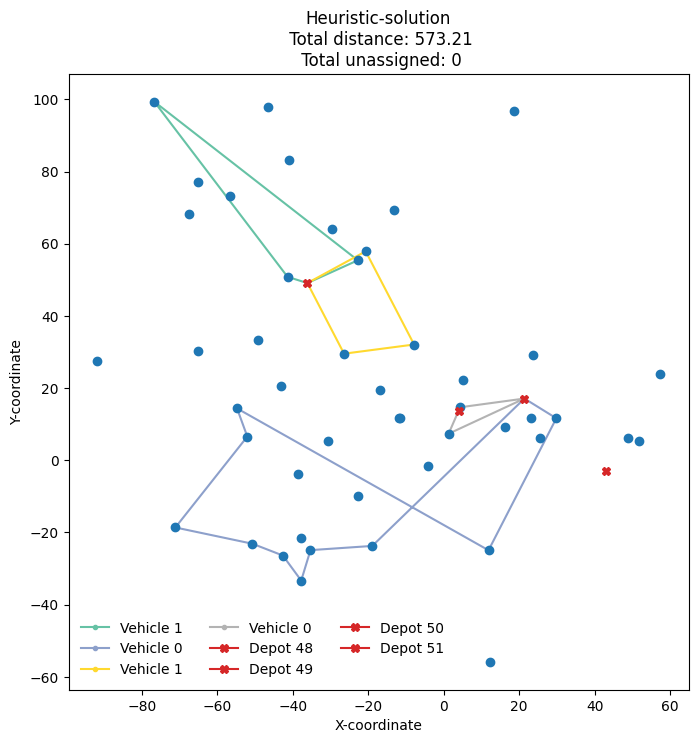

In [30]:
plot_solution(data, initial_solution, "Nearest-neighbor-solution", save=False, figsize=(8, 8))
plot_solution(data, solution, "Heuristic-solution", idx_annotations=False, save=False, figsize=(8, 8))

In [31]:
print(f"There are {len(initial_solution.routes)} routes")
served_customers = 0
for route in initial_solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data["depots"]]
    served_customers += len(customers)
    print(route.customers_list)

print(f"Total number of served customers: {served_customers}")


There are 5 routes
[50, 33, 50]
[51, 42, 9, 10, 13, 2, 45, 35, 6, 46, 7, 44, 34, 20, 51]
[50, 47, 29, 31, 41, 4, 39, 8, 15, 28, 26, 12, 24, 5, 19, 36, 37, 25, 14, 50]
[51, 22, 30, 23, 3, 11, 27, 1, 21, 18, 38, 17, 16, 51]
[50, 32, 40, 43, 50]
Total number of served customers: 47


In [32]:
# Calculating the late, early, ontime and left out customers
solution_stats = verify_time_windows(data, initial_solution, percentage=True)
print(solution_stats)

{'total_served': 57, 'early': 0.0, 'late': 63.2, 'ontime': 36.8, 'sum_early': 0, 'sum_late': 20676.860000000004}


In [33]:
print(f"There are {len(solution.routes)} routes")
served_customers = 0
for route in solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data['depots']]
    served_customers += len(customers)
    print(route.customers_list)


print(f"Total number of served customers: {served_customers}")
# Calculating the late, early, ontime and left out customers
solution_stats = verify_time_windows(data, solution)
print(solution_stats)

There are 4 routes
[51, 28, 13, 16, 51]
[50, 45, 42, 25, 15, 40, 38, 12, 21, 24, 43, 50]
[51, 14, 41, 36, 51]
[50, 35, 37, 50]
Total number of served customers: 18
{'total_served': 26, 'early': 5, 'late': 3, 'ontime': 18, 'sum_early': 412.59, 'sum_late': 548.12}


### Solution

In [34]:


# Example usage
# data = read_solution_format("path_to_file.txt", print_data=True)

bks = read_solution_format("/home/pettepiero/tirocinio/dial-a-ride/data/c-mdvrptw-sol/pr01.res", print_data=False)

In [35]:
print(bks.keys())
print(len(bks['routes']))

for route in bks["routes"]:
    print(route["customers"])

dict_keys(['solution_cost', 'routes', 'n_vehicles'])
8
[49, 9, 42, 46, 39, 15, 25, 26, 23, 36, 32, 49]
[49, 35, 44, 31, 41, 7, 37, 49]
[50, 34, 10, 45, 6, 27, 3, 48, 11, 50]
[50, 22, 50]
[51, 28, 4, 19, 14, 1, 16, 51]
[51, 13, 33, 20, 29, 8, 5, 17, 18, 51]
[52, 30, 52]
[52, 2, 47, 24, 12, 38, 40, 21, 43, 52]


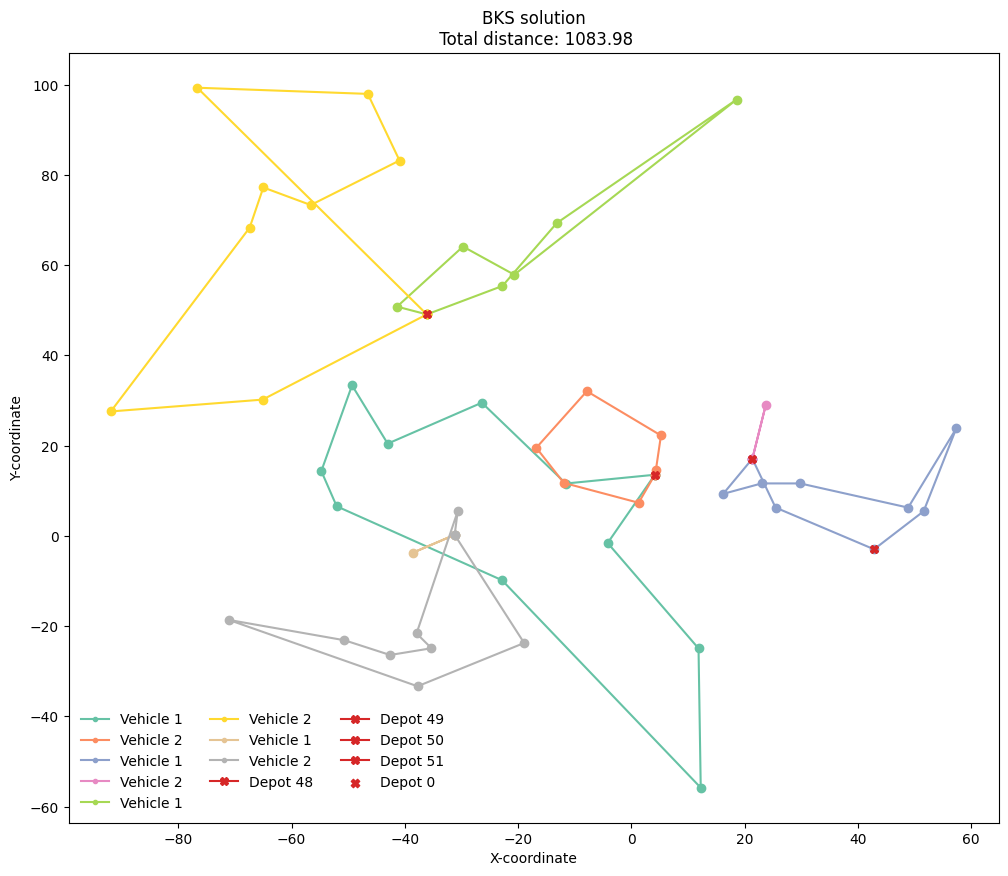

In [36]:
def plot_bks(data: dict, solution, name= "BKS", figsize=(12, 10), save=False):

    fig, ax = plt.subplots(figsize=figsize)
    cmap = plt.get_cmap("Set2", solution["n_vehicles"])
    cmap

    for idx, route in enumerate(solution["routes"]):
        ax.plot(
            [data["node_coord"][loc][0] for loc in route["customers"]],
            [data["node_coord"][loc][1] for loc in route["customers"]],
            color=cmap(idx),
            marker=".",
            label=f"Vehicle {route['vehicle']}",
        )
        for cust in route["customers"]:
            coords = data["node_coord"][cust]
            ax.plot(coords[0], coords[1], "o", c=cmap(idx))

    kwargs = dict(zorder=3, marker="X")

    for i in range(data["dimension"], data["dimension"] + data["n_depots"]):
        depot = data["node_coord"][i]
        ax.plot(depot[0], depot[1], c="tab:red", **kwargs, label=f"Depot {i}")

    ax.scatter(*data["node_coord"][0], c="tab:red", label="Depot 0", **kwargs)

    ax.set_title(f"{name}\n Total distance: {solution["solution_cost"]}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

    if save:
        plt.savefig(f"./plots/{name}.png")
        plt.close()

plot_bks(data, bks, "BKS solution",)

In [37]:
print(f"data['node_coord][0]: {data['node_coord'][0]}")

data['node_coord][0]: [None None]


In [38]:
print(bks)

{'solution_cost': 1083.98, 'routes': [{'day': 1, 'vehicle': 1, 'duration': 410.12, 'load': 131.0, 'customers': [49, 9, 42, 46, 39, 15, 25, 26, 23, 36, 32, 49], 'star_times': [0.0, 80.0, 115.35, 171.23, 246.09, 301.57, 332.83, 356.6, 378.0, 416.94, 456.0, 472.84]}, {'day': 1, 'vehicle': 2, 'duration': 179.98, 'load': 59.0, 'customers': [49, 35, 44, 31, 41, 7, 37, 49], 'star_times': [0.0, 159.0, 176.93, 200.0, 222.39, 248.75, 322.0, 332.14]}, {'day': 2, 'vehicle': 1, 'duration': 353.01, 'load': 119.0, 'customers': [50, 34, 10, 45, 6, 27, 3, 48, 11, 50], 'star_times': [0.0, 182.0, 195.18, 203.0, 231.8, 398.0, 440.24, 473.4, 510.1, 525.67]}, {'day': 2, 'vehicle': 2, 'duration': 47.42, 'load': 21.0, 'customers': [50, 22, 50], 'star_times': [0.0, 371.0, 406.21]}, {'day': 3, 'vehicle': 1, 'duration': 242.07, 'load': 63.0, 'customers': [51, 28, 4, 19, 14, 1, 16, 51], 'star_times': [0.0, 257.0, 279.91, 345.85, 414.07, 441.07, 460.75, 484.29]}, {'day': 3, 'vehicle': 2, 'duration': 480.13, 'load'